In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
from datasets import DatasetDict

ds_path = "/mnt/ceph/users/sgolkar/datasets/astroclip/spec_rs_chunked_ds"
ds = DatasetDict.load_from_disk(ds_path)

In [5]:
from fillm.run.model import *

def load_model_from_ckpt(ckpt_path: str):
    """
    Load a model from a checkpoint.
    """
    if Path(ckpt_path).is_dir():
        ckpt_path = Path(ckpt_path) / "ckpt.pt"

    chkpt = torch.load(ckpt_path)
    config = chkpt["config"]
    state_dict = chkpt["model"]
    model_name = config["model"]['kind']
    model_keys = get_model_keys(model_name)
    # config['log_encoding']=False
    # config['log_decoding']=False
    # config['only_pred_masked']=True
    # config['first_layer_norm']=True
    # config['mlp_layer_norm']=True
    
    model_args = {k: config['model'][k] for k in model_keys}

    model_ctr, config_cls = model_registry[model_name]
    model_config = config_cls(**model_args)
    model = model_ctr(model_config)
    model.load_state_dict(state_dict)

    return {"model": model, "config": config}

model_path = "/mnt/home/sgolkar/ceph/saves/fillm/run-seqformer-2708117"
out = load_model_from_ckpt(model_path)

config = out['config']
model = out['model'].to('cuda')
# model.eval()

print(model)

Seqformer(
  (data_embed): Linear(in_features=22, out_features=768, bias=True)
  (position_embed): Embedding(800, 768)
  (dropout): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-5): 6 x TransformerBlock(
      (layernorm1): LayerNorm()
      (attention): SelfAttention(
        (attention): Linear(in_features=768, out_features=2304, bias=True)
        (projection): Linear(in_features=768, out_features=768, bias=True)
        (attention_dropout): Dropout(p=0.0, inplace=False)
        (residual_dropout): Dropout(p=0.0, inplace=False)
      )
      (layernorm2): LayerNorm()
      (mlp): MLP(
        (activation): GELU(approximate='none')
        (encoder): Linear(in_features=768, out_features=3072, bias=True)
        (decoder): Linear(in_features=3072, out_features=768, bias=True)
      )
    )
  )
  (final_layernorm): LayerNorm()
  (head): Linear(in_features=768, out_features=22, bias=True)
)


In [6]:
import torch
from torch import nn

In [7]:
class RedshiftPredictor(nn.Module):
    """ Tries to predict the redshift from the 
    pre-trained transformer model
    """
    
    def __init__(self, model):
        super(RedshiftPredictor, self).__init__()
        self.transformer = model
        self.projection = nn.Linear(22, 1)
        self.class_token = nn.Parameter(torch.ones([13]))
    
    def forward(self, x):
        # Replacing the input by the empty prediction token
        x[:,0] = self.class_token 
        
        # Feeding all of that to our transformer model
        x  = self.transformer(x)['preds']
        
        # Using the class token to form a prediction for redshift with a linear
        # head
        x = self.projection(x[:,0])
        
        return x

In [8]:
predictor = RedshiftPredictor(model)
predictor = predictor.to('cuda')

In [9]:
ds.set_format(type='torch')
dataloader = torch.utils.data.DataLoader(ds['train'], 
                                         batch_size=64, 
                                         num_workers=10,
                                         shuffle=True, pin_memory=True)

In [11]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

learning_rate = 1e-5
epochs = 5

criterion = nn.MSELoss().to('cuda')
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=1, gamma=0.1)

losses = []
predictor.train()

for epoch in range(epochs):  # loop over the dataset multiple times
    
    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs = data['x'].to('cuda')
        labels = inputs[:,0,2].clone()
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = predictor(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        # print
        if i % 10 == 0:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {loss.item():.3f}')
            
    scheduler.step()

ValueError: Cannot forward sequence of length 1556, block size is only 800

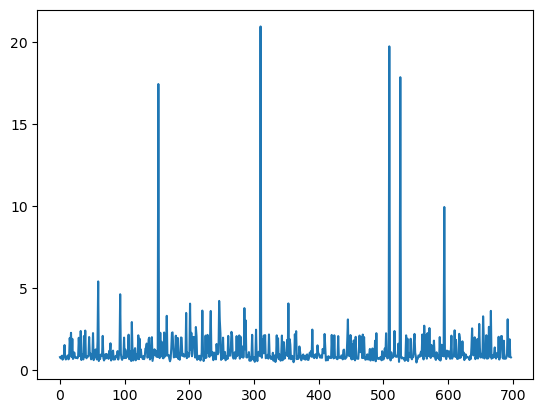

In [10]:
plot(losses[20:])

In [11]:
f = lambda z: z * 0.15 + 0.2

(0.0, 1.0)

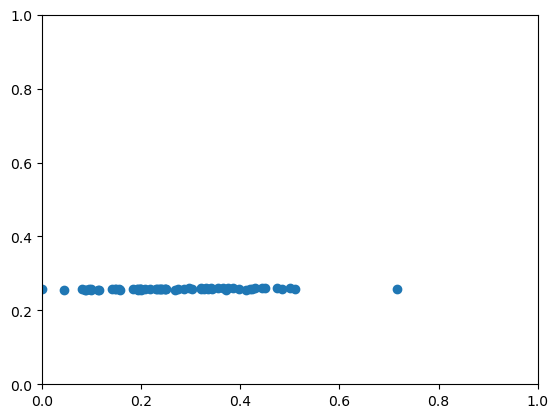

In [12]:
scatter(f(labels.cpu().detach().numpy()), 
        f(predictor(inputs).cpu().detach().numpy()))
xlim(0,1)
ylim(0,1)